In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time
from mpl_toolkits.mplot3d import Axes3D
import h5py

In [88]:
params = {"ytick.color" : "g",
          "xtick.color" : "g",
          "axes.labelcolor" : "g",
          "axes.edgecolor" : "g",
          "text.color" : "g",
         }
plt.rcParams.update(params)

In [101]:
## Setting Boundary conditions for each split electrode with unique central hole sizes

delta = .0001 ## 100 micrometer precision

lenX = .120 # range we are looking at (120 mm)
range_x = np.arange(0, lenX, delta)
lenZ = .0508/2.0 ## the distance between your plates
range_z = np.arange(-lenZ/2, lenZ/2, delta)

hole_radii = np.arange(200e-6, 1.6e-3, 200e-6)

fopt = 2 - (2*np.pi)/float(len(range_z))

#BCs
#Ttop = 50  ## insert gaussian beam profile for IFO beam heating (right now it is just a delta function BC)
V_o = 25.0 ## Voltage applied to plates
Utop = V_o
Ubottom = -1.0*V_o
Uleft = 0
Uright = 0

# Initial guess of what the temperature of inside will be
Uguess = 0

#Set meshgrid
X, Z = np.meshgrid(range_x, range_z)

## Hole size is a fraction of the range you are looking at.. what is that fraction and what is that relative to the plate size?
U = np.empty((len(range_z), len(range_x), len(hole_radii)))
U_before = np.empty((len(range_z), len(range_x), len(hole_radii)))
U.fill(Uguess)
    
#Set BC
## Plates are finite, establish size
rad_plate = .040

near_side = int(round((1.0/2.0*len(range_x)- rad_plate/delta)))
far_side = int(round((1.0/2.0*len(range_x)+ rad_plate/delta)))

U[(len(range_z)-1):,near_side:far_side,:] = Utop
U[:1, near_side:far_side,:] = Ubottom
U[:, (len(range_x)-1):, :] = Uright
U[:, :1,:] = Uleft

##Making holes in plates
for i in np.arange(0,len(hole_radii)):
    first_half = int(round((1.0/2.0*len(range_x)- hole_radii[i]/delta)))
    second_half = int(round((1.0/2.0*len(range_x)+ hole_radii[i]/delta)))

    U[(len(range_z)-1):,first_half:second_half,i] = 0
    U[:1, first_half:second_half,i] = 0


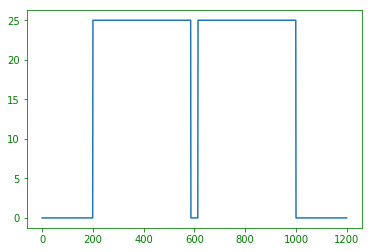

In [106]:
plt.plot(U[(len(range_z)-1):,:,6].T)

In [90]:
for k in np.arange(0,len(hole_radii)):
    # Iteration
    print("Please wait for a moment")
    conv = 3
    count = 0
    start = time.time()
    while conv > 2: 
        conv = np.sum(np.abs(U[:,:,k]-U_before[:,:,k]))
        print(conv)
        U_before[:,:, k] = U[:,:, k]
        for j in range(1, len(range_x)-1):
            for i in range(1, len(range_z)-1):
                U[i, j, k] = (1-fopt) * U[i, j, k] + fopt*.25*(U[i+1][j][k] + U[i-1][j][k] + U[i][j+1][k]+ U[i][j-1][k])
    
        for j in range(1, len(range_x)-1)[::-1]:
            for i in range(1, len(range_z)-1)[::-1]:
                U[i, j, k] = (1-fopt) * U[i, j, k] + fopt*.25*(U[i+1][j][k] + U[i-1][j][k] + U[i][j+1][k]+ U[i][j-1][k])
                #T[i,j] = .25*(T[i+1][j] + T[i-1][j] + T[i][j+1]+ T[i][j-1])
        count += 1
    elapsed = time.time() - start
    
    print("Iteration finished after {} iterations and took {} seconds".format(count, elapsed))

Please wait for a moment
39850.0
822487.844583121
53982.789974523956
50667.193282647495
48436.929147318
46556.96028375764
44860.52604169747
43288.433671349565
41812.351920270106
40417.43683564196
39092.80344544176
37831.185725284224
36626.98523392402
35474.479759765854
34369.52472006953
33308.720006284355
32289.328152346283
31309.150086365473
30366.231642460734
29458.51257028213
28584.059783531244
27741.125079756755
26928.004938731967
26143.197933368483
25385.384740941616
24653.311531549523
23945.802361774146
23261.748031133957
22600.22025859223
21960.267995733135
21340.947096708478
20741.488962522017
20161.160966274263
19599.204729055447
19054.863431255555
18527.576232647974
18016.647079509694
17521.55695088285
17041.68236948279
16576.546529464296
16125.548508174257


KeyboardInterrupt: 

In [7]:
file = h5py.File('numerical_split_electrode_test_R{}_r_hole{}.h5'.format(count), 'w')
file.create_dataset('X', data=X)
file.create_dataset('Z', data=Z)
file.create_dataset('V_o', data=V_o)
file.create_dataset('lenX', data= lenX)
file.create_dataset('lenZ', data=lenZ)
file.create_dataset('Potential', data=U)
file.create_dataset('iterations',data=count)
file.create_dataset('delta', data=delta)
file.create_dataset()
file.close()

NameError: name 'V_o' is not defined

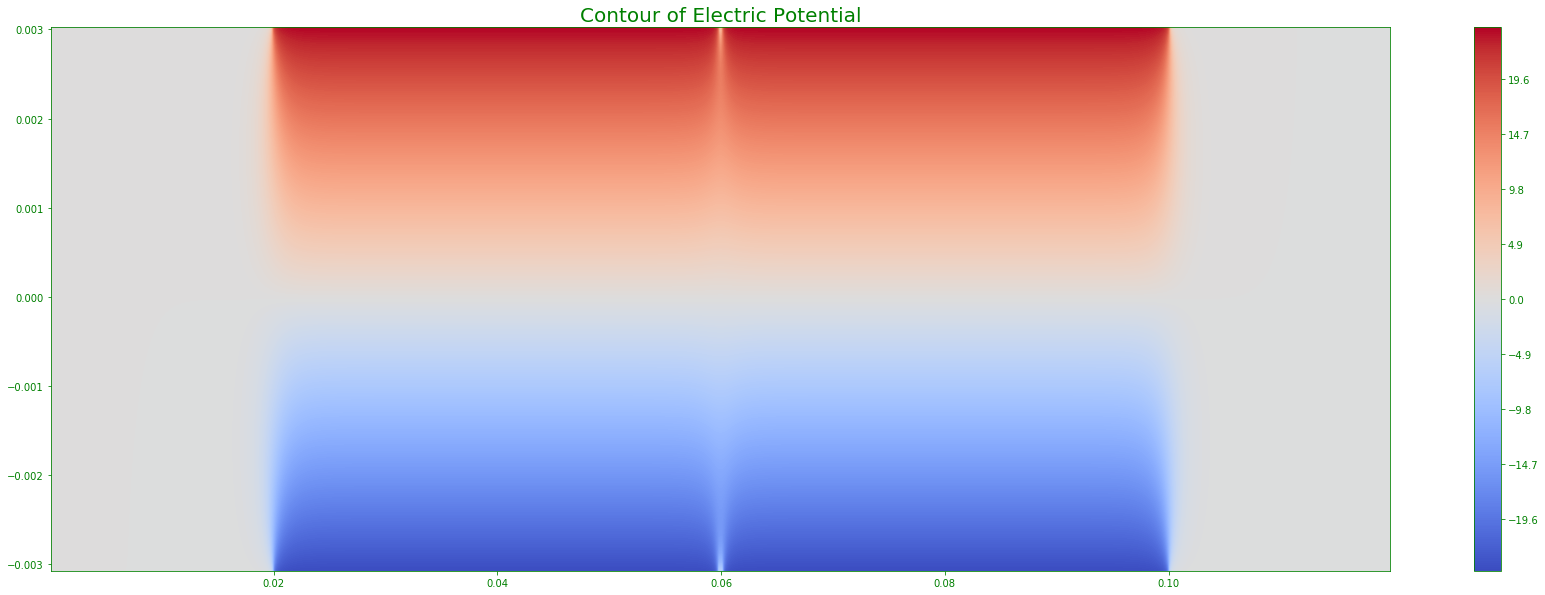

In [82]:
#Set interpolation and colormap
colorinterp = 1000
colormap = plt.cm.coolwarm
figure = plt.figure(figsize=(30,10))
plt.contourf(X[1:-1,1:-1],Z[1:-1,1:-1],U[1:-1,1:-1, 0], colorinterp, cmap=colormap)
plt.title("Contour of Electric Potential", fontsize=20)
#Set Colorbar
plt.colorbar()
#Show the result in the plot winow
plt.show()
print("")

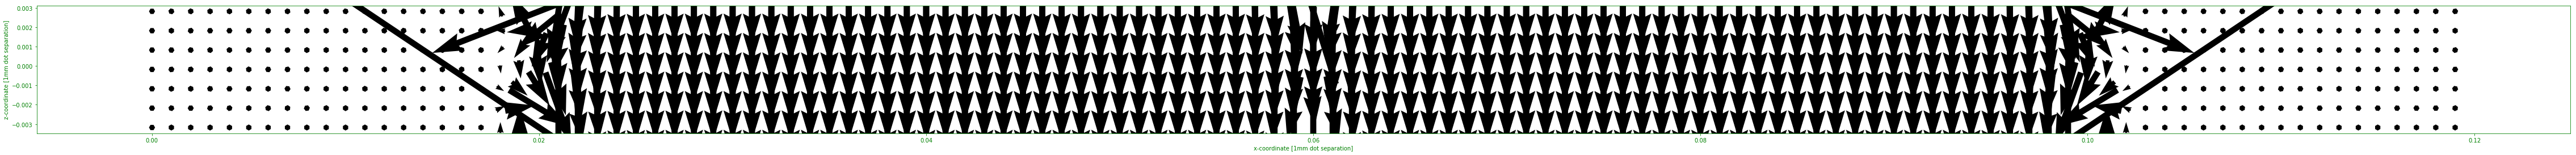

In [84]:
E_U = np.empty((len(range_z),len(range_x)))
E_V = np.empty((len(range_z),len(range_x)))

#grad_span = 1
skip = 10
E_U, E_V = np.gradient(U[:,:,0], delta)
E_U = -1.0*E_U
E_V = -1.0*E_V

X_new = X
#Y_new = Y[grad_span:-grad_span,grad_span:-grad_span]
Z_new = Z
fig, ax = plt.subplots(figsize=(80, 40))
q = ax.quiver(X[::skip,::skip], Z[::skip,::skip], E_V[::skip,::skip], E_U[::skip,::skip], units='xy', pivot='mid', cmap='magma')
ax.set_aspect('equal')
plt.xlabel('x-coordinate [1mm dot separation]')
plt.ylabel('z-coordinate [1mm dot separation]')
plt.show()

In [109]:
len(range_z)
len(range_x)

1200

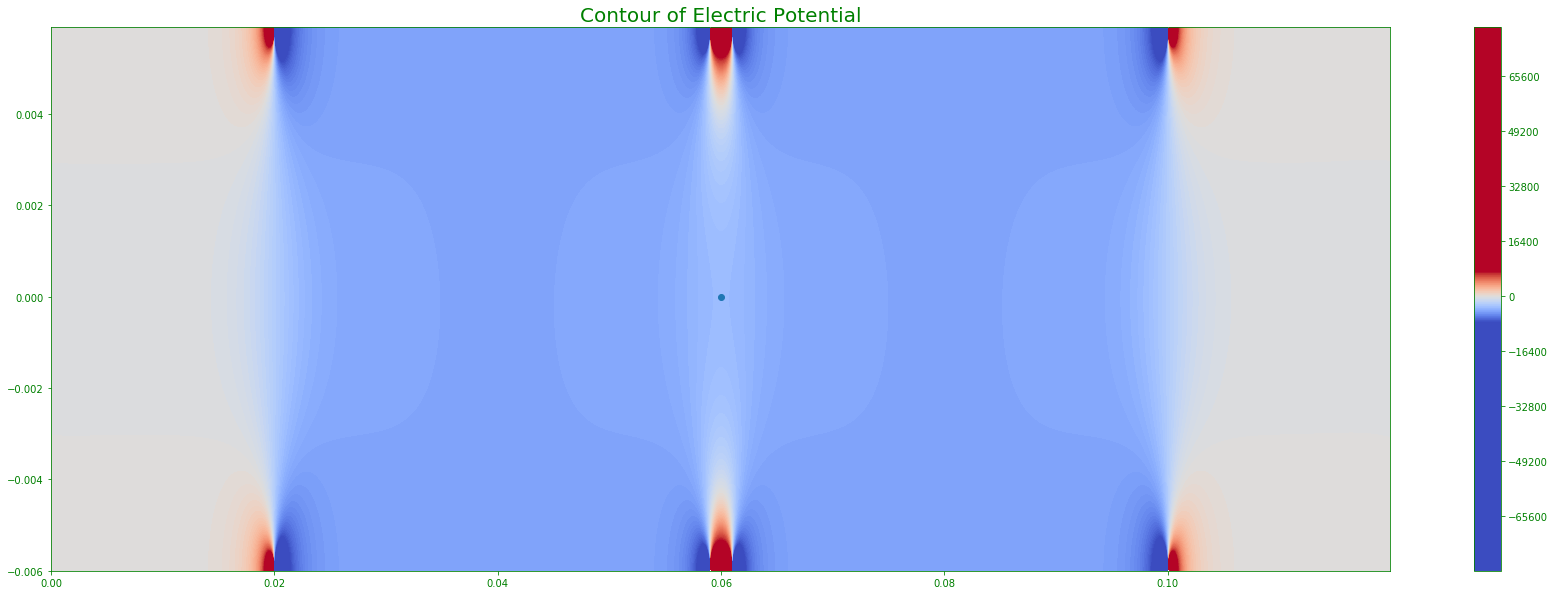

In [26]:
figure = plt.figure(figsize=(30,10))
plt.contourf(X,Z,E_U, colorinterp, cmap=colormap)
plt.title("Contour of Electric Potential", fontsize=20)
#Set Colorbar
plt.colorbar()
plt.clim(vmin=-7500, vmax=7500)
plt.scatter(lenX/2.0, 0)
#Show the result in the plot winow
plt.show()
print("")

In [39]:
E_center = E_U[len(range_z)/2, len(range_x)/2]
U_center = U[len(range_z)/2, len(range_x)/2]
print(E_center, U_center)

(-3168.700487527855, 0.15738422403195618)


In [28]:
for i in range(0, len(X[0][:])-1): 
    if X[0][i] == .06: 
        print i
        
for j in range(0, len(Y[:,0])-1): 
    if Y[j,0] == -0.005: 
        print j

In [147]:
E_U[len(range_y)/2,len(range_x)/2]

0.00010172704805194783

In [37]:
x_center = len(range_x)/2

In [40]:
E_fluxrad = E_U[len(range_z)/2,x_center:x_center+5]

In [44]:
np.sum(E_fluxrad)*2*np.pi

-99674.910762857